<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.yolo as yolo

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bike'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
add_proper_labels(annotations)

In [6]:
annotations = np.asarray(annotations)

In [7]:
counts = get_label_counts(annotations)

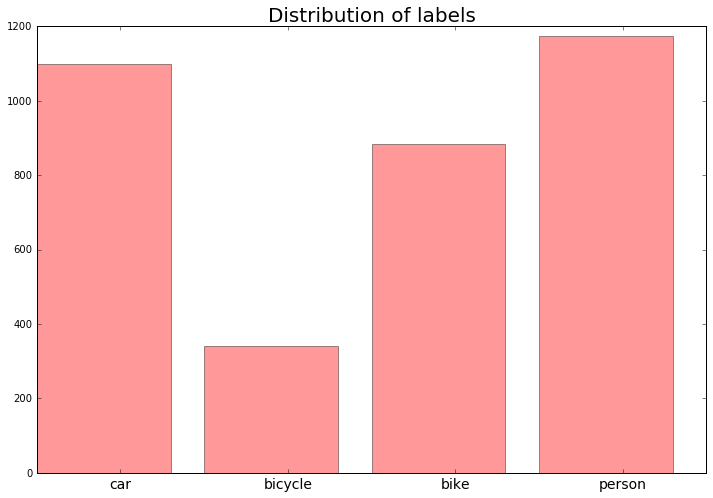

In [8]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [9]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [10]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [11]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [12]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, self.xi)
        yi = max(0, self.yi)
        xf = min(im.shape[1], self.xf)
        yf = min(im.shape[0], self.yf)
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [13]:
def generate_data(annotations, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + 4))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [184]:
net = {}
net['input'] = InputLayer((None,3,200,200))
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['pool3'] = Pool2DLayer(net['conv6'], (2,2))
net['conv7'] = Conv2DLayer(net['pool3'], 64, (3,3))
net['conv8'] = Conv2DLayer(net['conv7'], 64, (3,3))
net['pool4'] = Pool2DLayer(net['conv8'], (2,2))
net['dense1'] = DenseLayer(dropout(net['pool4'], p=.8), 1000)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.8), 1000)
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [15]:
with open('pretrained_weights.pkl', 'rb') as f:
    weights = pk.load(f)
    lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [185]:
S = (9,9)
B = 2
C = 4

In [186]:
net['dense1'] = DenseLayer(dropout(net['pool4'], p=.8), 2048)
net['output'] = DenseLayer(dropout(net['dense1'], p=.8), (S[0] * S[1]) * (5 * B + C), nonlinearity=None)

In [187]:
load_weights = True
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [188]:
num_epochs = 100
batch_size = 100

In [189]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [190]:
yl = yolo.YoloObjectDetector(net, (None, 3, 200, 200), C, S, B) 

In [191]:
train_loss, test_loss = yl.train(
    generate_data(train_annotations),
    generate_data(test_annotations),
    lr=1e-3,
    epochs=num_epochs
)

Getting cost...
Creating cost variable took 0.3655 seconds
Compiling...


  0%|          | 0/100 [00:00<?, ?it/s]

Compiling functions took 23.1563 seconds
Beginning training...
3845.63500977
9303.125
8965.02050781
12546.203125
5475.17871094
5380.48730469
5013.58740234
4594.92138672
5777.11621094
4906.38818359
4074.66967773
4648.234375
4902.33886719
4602.8125
4628.10791016
3805.05981445
5064.06640625
5408.67724609
4840.05615234
4328.55322266
3914.72998047
4188.66699219
4276.40136719
4984.31005859
4689.79785156
4146.13427734
4704.30712891
5074.08837891
4231.98632812
4121.28515625
4444.38525391
3742.04785156
3512.15698242
4178.27050781
3649.62988281
3702.47583008
3168.88720703


  1%|          | 1/100 [03:46<6:12:56, 226.03s/it]

Epoch 0
------
Train Loss: 4941.6157, Test Loss: 5481.7593
4343.97998047
4079.84375
4073.89013672
3751.10424805
3837.41894531
4466.95800781
4432.82910156
4159.91113281
4789.60205078
4765.58789062
4023.20825195
4641.99853516
5287.07226562
4976.19921875
4377.03271484
3907.60205078
4628.12353516
5114.47314453
5011.96582031
3829.28271484
3388.01025391
4026.51806641
4200.06445312
4868.29882812
4165.26806641
4092.98925781
4151.88378906
4177.1484375
4275.36181641
3843.41259766
4270.97851562
3414.5546875
3637.62158203
4095.67041016
3584.3684082
3875.71875
3315.53735352


  2%|▏         | 2/100 [04:28<4:39:00, 170.82s/it]

Epoch 1
------
Train Loss: 4213.0137, Test Loss: 5623.3276
4297.54882812
3773.99902344
4930.56933594
4478.71386719
3681.3684082
4002.22167969
4098.56787109
3820.96923828
4090.65234375
4235.56640625
3583.34985352
4172.27099609
4700.00585938
5019.47851562
4697.41064453
3947.16967773
4689.35546875
4762.29931641
4516.87988281
3653.16992188
3430.09765625
3807.84277344
3785.71020508
4512.21826172
4479.38427734
4136.52783203
3628.23535156
4377.29638672
4199.23046875
3773.31445312
4052.34863281
3463.89282227
3487.8918457
4334.45996094
3978.84619141
3755.92626953
3288.55859375


  3%|▎         | 3/100 [05:10<3:33:41, 132.18s/it]

Epoch 2
------
Train Loss: 4098.4683, Test Loss: 5146.4248
4191.50097656
4209.41455078
4049.57324219
3451.24658203
3433.24560547
4192.29589844
3963.63964844
3836.39233398
4289.12451172
3873.04882812
3224.70922852
4062.40795898
4317.09082031
4634.56787109
4116.12353516
4039.05859375
5276.72998047
4892.79150391
4640.73242188
3670.97753906
3341.16333008
3824.57666016
4067.40722656
4707.64648438
4320.33056641
4492.45019531
3698.47583008
4624.22509766
4173.42382812
3802.08276367
4176.00244141
3430.4309082
3268.60522461
4261.12402344
3226.08496094
3599.35961914
3310.3671875


  4%|▍         | 4/100 [05:52<2:48:12, 105.13s/it]

Epoch 3
------
Train Loss: 4018.6055, Test Loss: 5546.9224
4156.48632812
3733.92285156
4177.98974609
3495.53735352
3071.19897461
4094.86816406
4220.91699219
3825.06494141
4255.03173828
4142.26318359
3437.97558594
3761.13037109
4241.40429688
4658.60205078
4331.97851562
3788.01123047
4570.82373047
4846.24169922
5191.73925781
3823.78295898
3526.46264648
4036.4934082
4016.35571289
4483.4609375
3957.36865234
3819.15283203
3565.40722656
3784.04931641
4270.21679688
3730.35693359
3951.90356445
3404.7734375
3674.23364258
4240.61181641
3198.07568359
3485.09350586
3052.73852539


  5%|▌         | 5/100 [06:34<2:16:28, 86.19s/it] 

Epoch 4
------
Train Loss: 3946.5330, Test Loss: 5944.6782
4090.88964844
3782.12402344
4230.38867188
4353.85742188
3680.02832031
4304.29003906
4161.06542969
3496.85424805
4255.41064453
3871.43530273
3170.11865234
3685.84912109
3855.63330078
4348.64208984
4311.97167969
4218.17236328
5154.32861328
4779.39550781
4523.58544922
3396.93066406
3487.59326172
3852.97094727
3656.86621094
4273.12646484
3863.42456055
3426.69799805
3825.17919922
4027.27172852
4170.22021484
3739.80737305
4032.21899414
3291.80126953
3348.08740234
4055.98510742
3105.19506836
3462.68310547
3141.28710938


  6%|▌         | 6/100 [07:16<1:54:15, 72.94s/it]

Epoch 5
------
Train Loss: 3903.5508, Test Loss: 5007.3110
3656.79248047
3478.10424805
3669.70166016
3343.47338867
4123.36767578
4342.37890625
4076.58154297
3678.87036133
4177.46826172
3677.80810547
3628.43115234
3840.76782227
4504.37011719
4059.99365234
4082.85717773
3357.30957031
4469.46728516
4999.65625
5644.80957031
3793.68017578
3508.05615234
4110.00878906
3812.16113281
4027.35351562
3722.92700195
3582.03662109
3414.78686523
4114.23730469
3762.45483398
3372.3059082
3956.64477539
3600.46972656
3213.29052734
4074.2800293
3079.91870117
3555.40893555
3216.10888672


  7%|▋         | 7/100 [07:58<1:38:40, 63.66s/it]

Epoch 6
------
Train Loss: 3857.5225, Test Loss: 5774.5312
4192.03564453
3254.97412109
3504.18530273
3263.54956055
3485.51953125
4453.79003906
4352.54931641
3610.55517578
4029.75415039
3706.51489258
3087.84082031
3882.6940918
4266.74804688
4294.0859375
3889.96166992
3293.40600586
4016.30004883
4597.30908203
4677.85449219
3794.26977539
3996.70092773
3900.60302734
3726.02050781
3868.81103516
3935.91821289
3609.89550781
3570.38989258
3888.30932617
3965.95410156
3415.81030273
4179.55273438
3421.72265625
3515.73388672
4070.78076172
3259.27661133
3336.55126953
2721.62939453


  8%|▊         | 8/100 [08:40<1:27:39, 57.16s/it]

Epoch 7
------
Train Loss: 3784.7986, Test Loss: 5035.7817
3718.37524414
3204.53515625
3625.64208984
3191.74267578
3088.84863281
3937.90893555
4170.95654297
3994.01049805
4249.94042969
4020.67138672
3473.0402832
3754.3762207
4190.55664062
4211.12841797
3649.54467773
3411.52050781
3991.24072266
4192.30224609
4258.33007812
3484.76000977
3118.23876953
3938.19946289
3719.5246582
4147.91113281
4001.68969727
3767.40551758
3324.93603516
3834.8449707
3729.25488281
3061.0402832
3733.17138672
3270.2824707
3298.53222656
3974.10693359
2985.73193359
3251.64672852
2819.74926758


  9%|▉         | 9/100 [09:22<1:19:48, 52.62s/it]

Epoch 8
------
Train Loss: 3670.1541, Test Loss: 4872.4697
3840.44702148
3632.13989258
3553.42749023
3454.49414062
3409.15844727
3714.41113281
3938.95117188
3547.70385742
3956.5546875
3798.14404297
3234.27832031
4063.97583008
4822.82421875
4163.94677734
3729.88256836
3477.47265625
3835.61523438
4220.1640625
4276.89257812
3422.40527344
3099.42651367
3903.79370117
3568.87915039
3991.35131836
3636.82421875
3268.90698242
3585.09936523
3607.90600586
3846.06713867
3282.35888672
3783.04296875
3207.18798828
3545.68603516
4261.47070312
3272.66162109
3202.09545898
2626.89794922


 10%|█         | 10/100 [10:04<1:14:09, 49.44s/it]

Epoch 9
------
Train Loss: 3669.7986, Test Loss: 5108.8433
3672.40454102
3120.16577148
3506.76293945
3009.97363281
3071.23535156
4097.75292969
4039.77587891
3818.52416992
4169.33691406
3724.50537109
3281.26123047
3455.78173828
3618.83642578
4092.53027344
3675.01757812
3321.25683594
4202.6484375
4097.77636719
4003.00146484
3295.32983398
3378.64550781
3733.36474609
3224.49584961
4184.04101562
4012.71411133
3748.11767578
3415.1027832
3941.49511719
4047.92016602
3255.19165039
3517.06445312
3243.99951172
2932.11035156
3986.55981445
3158.02246094
3150.09130859
2878.30444336


 11%|█         | 11/100 [10:46<1:10:01, 47.21s/it]

Epoch 10
------
Train Loss: 3596.7871, Test Loss: 5509.6187
3966.89208984
3312.43188477
4193.49609375
3031.6496582
3038.14208984
3347.73876953
3468.59423828
3496.62841797
3613.30859375
3828.96679688
2910.96362305
4444.05810547
4874.14648438
5157.32666016
4374.45263672
3267.92382812
3887.1418457
3950.33129883
4214.67724609
3259.86474609
2868.41577148
3764.73461914
3709.24633789
3806.56787109
3624.03759766
3316.21166992
3231.53515625
3283.31640625
3653.25683594
3321.83178711
3424.03051758
2912.87353516
3244.8815918
3672.71704102
3257.24072266
3105.13012695
3049.08447266


 12%|█▏        | 12/100 [11:28<1:06:57, 45.65s/it]

Epoch 11
------
Train Loss: 3591.4556, Test Loss: 5917.3706
3803.46801758
3560.64453125
3657.71362305
2894.03027344
3001.95947266
3719.24072266
3465.73535156
3782.21191406
3640.79150391
3545.35205078
2936.9152832
3879.61328125
4096.68164062
3991.19995117
3704.81738281
3105.87597656
3840.38623047
3970.57397461
4627.62744141
3597.28173828
3249.5065918
3708.21875
3648.71557617
3981.73242188
3625.56591797
3000.7512207
3111.1184082
3526.33300781
3766.72998047
3407.95458984
4207.32128906
3786.34692383
3389.29931641
4147.93310547
2879.11230469
2812.73046875
2724.97729492


 13%|█▎        | 13/100 [12:10<1:04:36, 44.56s/it]

Epoch 12
------
Train Loss: 3562.0667, Test Loss: 4885.7129
3442.0612793
3325.82421875
3568.18969727
3175.51806641
3651.81835938
3250.05493164
3202.67431641
3184.16503906
3340.85449219
3488.17138672
2886.98681641
3643.53881836
4070.37915039
3890.42578125
3785.51049805
3088.12304688
3834.25097656
4222.55078125
4025.02685547
3517.71020508
3155.28222656
3613.4934082
3379.28564453
3812.94995117
3515.47314453
3447.15307617
3879.90136719
3742.71557617
3595.31640625
3437.07324219
3566.47363281
3023.77050781
2951.40307617
3876.42553711
2886.72143555
2988.07006836
2755.77978516


 14%|█▍        | 14/100 [12:52<1:02:46, 43.80s/it]

Epoch 13
------
Train Loss: 3465.4355, Test Loss: 5574.5640
3823.88671875
3507.18066406
3719.30151367
3054.94335938
3067.37329102
3497.73461914
3542.01269531
3129.35693359
3445.2265625
3334.13183594
2629.94677734
3567.63964844
3763.46411133
3948.49511719
3853.64794922
3381.91943359
4318.35693359
4865.83496094
6507.92138672
4062.88891602
2886.97412109
3782.60595703
3236.03710938
3642.86865234
3810.02368164
3449.96484375
3217.23535156
3684.8527832
3591.69458008
2951.3581543
3592.34838867
2882.42749023
2977.31933594
3606.72973633
2637.80322266
2889.20019531
2539.2956543


 15%|█▌        | 15/100 [13:34<1:01:17, 43.27s/it]

Epoch 14
------
Train Loss: 3524.3245, Test Loss: 5076.8887
3373.38647461
2894.36083984
3315.92041016
2990.54345703
3393.18066406
3541.95166016
3478.45458984
3072.39428711
3409.44824219
3596.84277344
2776.53759766
3540.83056641
3591.56567383
4344.21826172
3634.50244141
3037.27563477
3822.57568359
4150.47460938
3859.86865234
2997.37255859
2918.45288086
3664.3894043
3359.41162109
4221.43798828
3877.21240234
3247.21020508
3411.58154297
3694.29321289
3616.02246094
3350.6940918
3460.04858398
3416.24511719
3295.6315918
4102.45214844
3058.62915039
3048.22070312
2790.99389648


 16%|█▌        | 16/100 [14:16<1:00:02, 42.89s/it]

Epoch 15
------
Train Loss: 3442.0171, Test Loss: 5228.4692
3340.64990234
3039.47265625
3606.76733398
2710.91235352
2546.56542969
3436.76635742
3420.18701172
3044.06713867
3678.31689453
3075.10986328
3064.93286133
4545.17089844
4364.29296875
4991.49951172
3951.25805664
3186.67773438
3653.37451172
3807.53637695
3641.69580078
3561.05908203
2907.00585938
3387.97949219
3403.5246582
3693.30151367
3276.51489258
3178.10083008
3130.03686523
3459.78955078
3750.51416016
3570.53051758
3739.73828125
3086.67822266
3442.88964844
3933.48461914
2647.1496582
2981.20410156
2844.65112305


 17%|█▋        | 17/100 [14:58<58:58, 42.63s/it]  

Epoch 16
------
Train Loss: 3435.1191, Test Loss: 5057.6094
3522.52026367
3001.609375
3344.08520508
2751.68261719
2927.42163086
3413.63964844
3163.63085938
3251.72998047
3414.20068359
3544.54980469
2850.88427734
3755.45019531
4552.40283203
4563.359375
3917.73388672
3616.0090332
3932.93408203
3859.41015625
3901.24047852
3290.18017578
3225.89550781
3733.58837891
3315.65332031
3822.67333984
3414.05664062
3370.57617188
3073.91088867
3702.65380859
3565.81811523
2943.54931641
3216.76782227
2933.08398438
3086.77270508
3741.99047852
2932.27880859
2838.19458008
2633.85449219


 18%|█▊        | 18/100 [15:40<58:00, 42.44s/it]

Epoch 17
------
Train Loss: 3408.8108, Test Loss: 5024.9805
3710.15039062
3449.33349609
3501.90429688
2840.19482422
3141.75610352
3455.41748047
3463.3190918
3450.67895508
3547.92504883
3397.32324219
2587.17431641
3521.2590332
3871.82568359
3942.26391602
3617.90380859
2923.42529297
3437.0715332
3654.17700195
4032.67456055
3127.03369141
3165.53613281
3915.87084961
3292.54370117
3877.29443359
3633.4621582
3383.14038086
3300.65698242
3661.37963867
3514.86767578
3084.06323242
3218.80810547
3126.34936523
3197.83251953
3706.66455078
2842.07910156
2957.75268555
2531.22265625


 19%|█▉        | 19/100 [16:22<57:07, 42.32s/it]

Epoch 18
------
Train Loss: 3380.6035, Test Loss: 5303.2344
3097.32421875
3144.48120117
3219.04296875
3062.51074219
2722.09326172
3308.7019043
3613.26049805
3146.5625
3495.4230957
3261.14257812
2517.19506836
3140.09667969
3352.27368164
3740.74072266
3594.58251953
3125.29785156
3794.32861328
3730.73754883
4036.64160156
2913.27832031
2782.81323242
3494.38720703
3294.43969727
4125.09082031
3971.93896484
3509.77490234
3025.62402344
3581.66992188
3409.69482422
2988.73291016
3406.30078125
2781.93457031
2952.02856445
3552.78222656
2655.05297852
2828.87255859
2740.68896484


 20%|██        | 20/100 [17:04<56:18, 42.23s/it]

Epoch 19
------
Train Loss: 3273.4473, Test Loss: 5129.5728
3373.125
2870.00366211
3168.48754883
2545.40771484
2838.15649414
3710.75292969
3565.83496094
3509.26196289
3475.67651367
3567.57763672
2890.90234375
3406.11499023
3535.69677734
3674.36694336
3327.64868164
3218.14892578
3512.81982422
3943.47314453
4468.15771484
3382.96972656
3386.14428711
3407.78857422
3381.63085938
3612.52099609
3145.13354492
2980.50488281
2993.43310547
3512.74462891
3524.23413086
2834.07324219
3282.40820312
2609.00610352
3150.2043457
3625.8203125
2751.90600586
2768.82299805
2632.1550293


 21%|██        | 21/100 [17:46<55:31, 42.16s/it]

Epoch 20
------
Train Loss: 3286.0300, Test Loss: 5172.4658
3262.10205078
2886.34106445
3396.86767578
2650.71435547
2622.73266602
3374.08740234
3627.03857422
3138.17871094
3461.05737305
3256.90136719
2786.39013672
4001.73071289
4444.8828125
4021.69189453
3793.63061523
2880.86474609
3493.88671875
3459.02172852
3958.0168457
3170.07666016
2740.84082031
3335.5
3348.5234375
3676.375
3428.14868164
3086.63500977
2995.63525391
3469.05566406
3558.19824219
2983.28491211
3317.75976562
2843.03710938
2774.56860352
3752.56274414
2749.33251953
2814.30053711
2624.75048828


 22%|██▏       | 22/100 [18:28<54:45, 42.12s/it]

Epoch 21
------
Train Loss: 3275.2627, Test Loss: 5276.2090
3490.71240234
3105.86206055
3412.56005859
2710.72363281
3126.29321289
3347.79101562
3436.23681641
3342.79101562
3534.06738281
3349.87426758
2843.13867188
3616.50537109
3361.12719727
3471.5637207
3510.4296875
2887.64160156
3392.07104492
3950.41430664
3663.98242188
3134.75805664
2789.75708008
3546.51342773
3268.59277344
3596.14086914
3290.74316406
3536.55639648
3566.59619141
3754.51855469
3888.48510742
3545.07446289
3245.03637695
2547.07592773
2779.60107422
3456.57324219
2508.38623047
2609.66479492
2573.47753906


 23%|██▎       | 23/100 [19:10<54:00, 42.09s/it]

Epoch 22
------
Train Loss: 3275.4414, Test Loss: 5218.6636
3375.23071289
2913.76464844
3453.01660156
2842.1484375
2669.38769531
3438.34375
3149.89550781
3161.86962891
3827.57885742
3248.96191406
2711.16210938
3201.24194336
3359.06396484
3732.37451172
3242.87695312
2939.21899414
3736.21044922
4324.73779297
4017.68286133
3152.52685547
2938.69604492
3353.9855957
3249.4284668
3832.37719727
3430.46948242
3153.70922852
3040.10888672
3545.29589844
3240.49145508
2972.3046875
3155.53710938
2699.45947266
2768.40258789
3600.37939453
2748.32202148
2766.7409668
2543.7512207


 24%|██▍       | 24/100 [19:52<53:17, 42.08s/it]

Epoch 23
------
Train Loss: 3230.7231, Test Loss: 5555.2451
3267.55908203
2928.97241211
3128.5078125
2420.79223633
2727.42773438
3090.41674805
3288.36987305
3156.47143555
3606.49707031
3397.51245117
2548.50537109
3085.89599609
3531.82275391
3521.16503906
3208.54467773
2913.91381836
3868.91699219
3807.91967773
4197.13623047
3408.15917969
3117.31225586
3911.10595703
3595.30566406
3717.10546875
2998.85424805
2988.39575195
3145.28857422
3219.38061523
3356.05810547
3161.6887207
3543.54125977
2789.12011719
2607.35766602
3532.83300781
2726.44921875
2627.42089844
2456.97216797


 25%|██▌       | 25/100 [20:34<52:34, 42.06s/it]

Epoch 24
------
Train Loss: 3205.3699, Test Loss: 5210.1362
3239.77880859
3063.49926758
3434.22607422
2925.54589844
2957.38476562
3387.57666016
3298.24169922
3583.99316406
3425.85058594
3384.56762695
2498.50366211
3416.73486328
3574.62597656
3472.92993164
3534.49902344
2729.70141602
3503.71728516
3539.2331543
3820.43261719
3507.66723633
2964.13037109
3641.86474609
3304.15917969
3651.46337891
3147.47314453
3236.54785156
3090.47216797
3341.19750977
3284.54882812
2814.11279297
3073.61645508
2929.01586914
2768.07275391
3573.81738281
2659.84594727
2487.73950195
2369.78759766


 26%|██▌       | 26/100 [21:16<51:51, 42.05s/it]

Epoch 25
------
Train Loss: 3206.3940, Test Loss: 5157.6255
3467.24243164
2791.65087891
3358.52441406
2545.70825195
3098.47485352
3348.375
3279.44775391
3075.68969727
3521.32861328
3294.40429688
2762.67822266
3250.88598633
3191.0703125
3675.79125977
3340.96069336
3195.6418457
4125.51074219
3460.11108398
3837.13745117
2835.58691406
2572.9765625
3407.93237305
3096.73022461
3525.43701172
3260.78637695
3225.12451172
2916.67333984
3097.64379883
3451.078125
3295.57470703
3455.48071289
2837.3894043
2768.77246094
3540.59326172
2607.875
2635.22094727
2433.95996094


 27%|██▋       | 27/100 [21:58<51:08, 42.04s/it]

Epoch 26
------
Train Loss: 3177.9856, Test Loss: 5248.4741
3070.33764648
2773.40527344
3228.76806641
2999.35327148
3328.36401367
3413.52148438
3449.16699219
3129.34228516
3069.90917969
3147.77587891
2344.58374023
3830.17944336
3705.5625
3787.70556641
3108.12036133
2674.80322266
3305.60009766
4202.77148438
3894.72631836
2994.93017578
2799.30273438
3201.53417969
3179.81689453
3668.10717773
3356.2175293
2808.92138672
2901.33007812
3242.34326172
3341.16064453
3012.2578125
3198.63305664
2630.32836914
2604.47314453
3395.23999023
2419.46484375
2584.70556641
2794.09716797


 28%|██▊       | 28/100 [22:40<50:26, 42.04s/it]

Epoch 27
------
Train Loss: 3151.2664, Test Loss: 5544.9106
3378.51245117
2977.0078125
3029.92431641
2528.83349609
2603.48901367
3026.0480957
2841.6796875
2993.59765625
3485.45288086
3397.18994141
2567.58129883
3352.22729492
3500.11401367
3443.32275391
3489.65283203
2916.81030273
3928.28881836
3640.09350586
3610.33618164
2649.91943359
2664.76074219
3344.82641602
3053.58666992
3812.15917969
2982.81835938
2956.58520508
3000.00415039
3188.44726562
3253.16870117
3281.76416016
3208.23095703
2558.77001953
2428.68212891
3225.73364258
2142.10473633
2679.9519043
2400.01123047


 29%|██▉       | 29/100 [23:22<49:44, 42.03s/it]

Epoch 28
------
Train Loss: 3068.6941, Test Loss: 4956.9956
3146.65820312
2768.21362305
3254.13427734
2467.06689453


In [192]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [193]:
# train_loss_total, test_loss_total = train_loss, test_loss
train_loss_total = np.concatenate((train_loss_total, train_loss))
test_loss_total = np.concatenate((test_loss_total, test_loss))

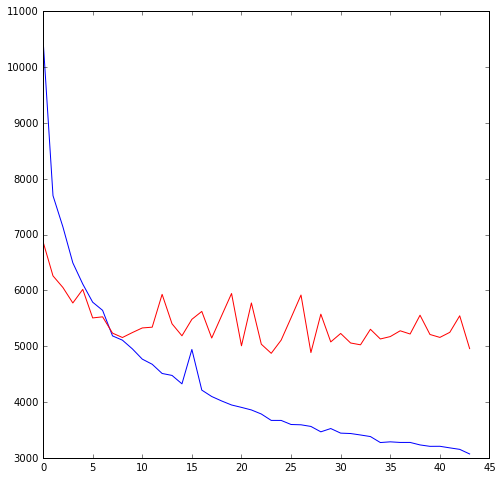

In [194]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [195]:
gen = generate_data(test_annotations[np.random.random_integers(0, test_annotations.size - 1, size=(100,))])

In [196]:
testdat = [t for t in gen]

In [197]:
Xtest, ytest = testdat[0]

In [198]:
out_fn = theano.function([yl.input], yl.output_test)

In [199]:
Xtest_out = out_fn(Xtest)

In [200]:
def draw_best(im, output):
    idx = (output[[4,9]] * output[-4:].max(axis=0,keepdims=True)).argmax()
    idx = np.unravel_index(idx, output[[4,9]].shape)
    coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
    obj_score = output[5 * idx[0] + 4, idx[1], idx[2]]
    class_score = output[-4:, idx[1], idx[2]]

    xi = int(coord[0] * im.shape[1] + 1./9 * idx[2])
    yi = int(coord[1] * im.shape[0] + 1./9 * idx[1])
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])

    xi, yi = max(0, xi), max(0, yi)
    xf, yf = max(im.shape[1]-1 , 0), max(im.shape[0]-1, 0)

    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]

    return draw_im, obj_score, class_score

In [201]:
def get_label_from_num(label):
    if label == 0:
        return 'car'
    elif label == 1:
        return 'bicycle'
    elif label == 2:
        return 'bike'
    elif label == 3:
        return 'person'
    elif label == 4:
        return 'noobj'
    else:
        return

In [202]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [209]:
N = int(Xtest.shape[0] * np.random.rand())

In [210]:
a,b,c = draw_best(swap(Xtest[N]), Xtest_out[N])

car with class score: 0.488, objectness: 0.535


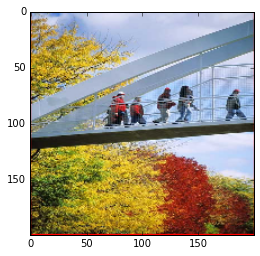

In [211]:
plt.imshow(a)
print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), b, c.max())

In [47]:
im = Xtest[0].swapaxes(0,1).swapaxes(1,2)

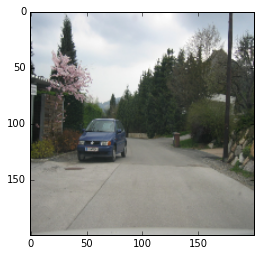

In [48]:
plt.imshow(im)